In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-24 14:17:54 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-24 14:17:54 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-24 14:17:54 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-24 14:17:59 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-24 14:17:59 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-24 14:18:00 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-24 14:18:00 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-24 14:18:00 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-24 14:18:00 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-09-24 14:18:00 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-09-24 14:18:00 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-24 14:18:01 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-24 14:18:49 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-24 14:18:49 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-24 14:18:49 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [6]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

# select_task.filter_single_token(tokenizer=mt.tokenizer, prefix=" ")

print(select_task)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(14), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [7]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Watermelon -> Strawberry (2): ['Phone', 'Skis', 'Strawberry', 'Clarinet', 'Sheep', 'Coffee table']
Options: Phone, Skis, Strawberry, Clarinet, Sheep, Coffee table.
Which among these objects mentioned above is a fruit?
Answer:


In [8]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Phone, Skis, Strawberry, Clarinet, Sheep, Coffee table.
Which among these objects mentioned above is a fruit?
Answer:" >> Strawberry


(True,
 [PredictedToken(token=' Strawberry', prob=0.60546875, logit=21.0, token_id=89077, metadata=None),
  PredictedToken(token=' The', prob=0.173828125, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.09326171875, logit=19.125, token_id=22395, metadata=None),
  PredictedToken(token=' A', prob=0.07275390625, logit=18.875, token_id=362, metadata=None),
  PredictedToken(token=' strawberry', prob=0.005950927734375, logit=16.375, token_id=73700, metadata=None)],
 OrderedDict([(89077,
               (1,
                PredictedToken(token=' Strawberry', prob=0.60546875, logit=21.0, token_id=89077, metadata=None))),
              (84008,
               (143,
                PredictedToken(token=' Sheep', prob=1.5735626220703125e-05, logit=10.4375, token_id=84008, metadata=None))),
              (31181,
               (169,
                PredictedToken(token=' Clar', prob=1.0788440704345703e-05, logit=10.0625, token_id=31181, metadata=None))),
          

In [9]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


" Strawberry
Explanation: Strawberry is a fruit. The other options are not fruits. Phone is an electronic" >> Strawberry


In [10]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [12]:
llama_70_heads = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]

qwen_72_heads = [
    (62, 1),
    (60, 9),
    (64, 8),
    (62, 0),
    (62, 45),
    (59, 59),
    (71, 28),
    (64, 12),
    (61, 7),
    (64, 13),
    (67, 53),
    (67, 51),
    (54, 44),
    (57, 5),
    (59, 60),
    (71, 25),
    (62, 7),
    (64, 9),
    (62, 23),
    (65, 40),
]

qwen_32_heads = [
    (51, 11),
    (48, 4),
    (52, 21),
    (54, 35),
    (48, 8),
    (50, 6),
    (48, 9),
    (48, 32),
    (52, 10),
    (45, 11),
    (45, 13),
    (48, 34),
    (53, 16),
    (50, 12),
    (49, 2),
    (54, 38),
    (55, 4),
    (50, 27),
    (54, 33),
    (50, 14),
]

# HEADS = [(35, 19)]
# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]

HEADS = qwen_32_heads
# HEADS = llama_70_heads
print(len(HEADS))

20


2025-09-24 14:19:08 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-09-24 14:19:08 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-09-24 14:19:08 matplotlib DEBUG    interactive is False
2025-09-24 14:19:08 matplotlib DEBUG    platform is linux
2025-09-24 14:19:09 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-09-24 14:19:09 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-09-24 14:19:09 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-24 14:19:09 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-24 14:19:09 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-09-24 14:19:09 matplotlib.font

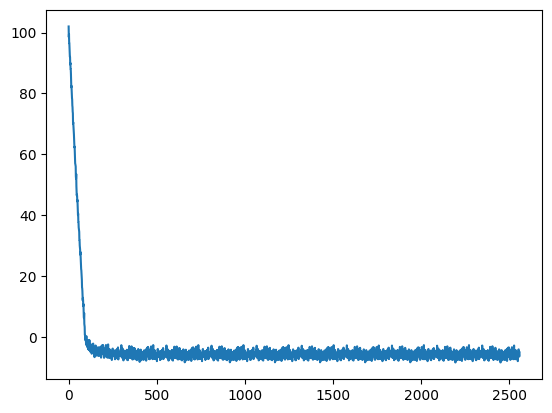

In [13]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_backup_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    # f"{select_task.task_name}",
    "select_one",
    # "legacy",
    "epoch_10.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

79


(True, True)

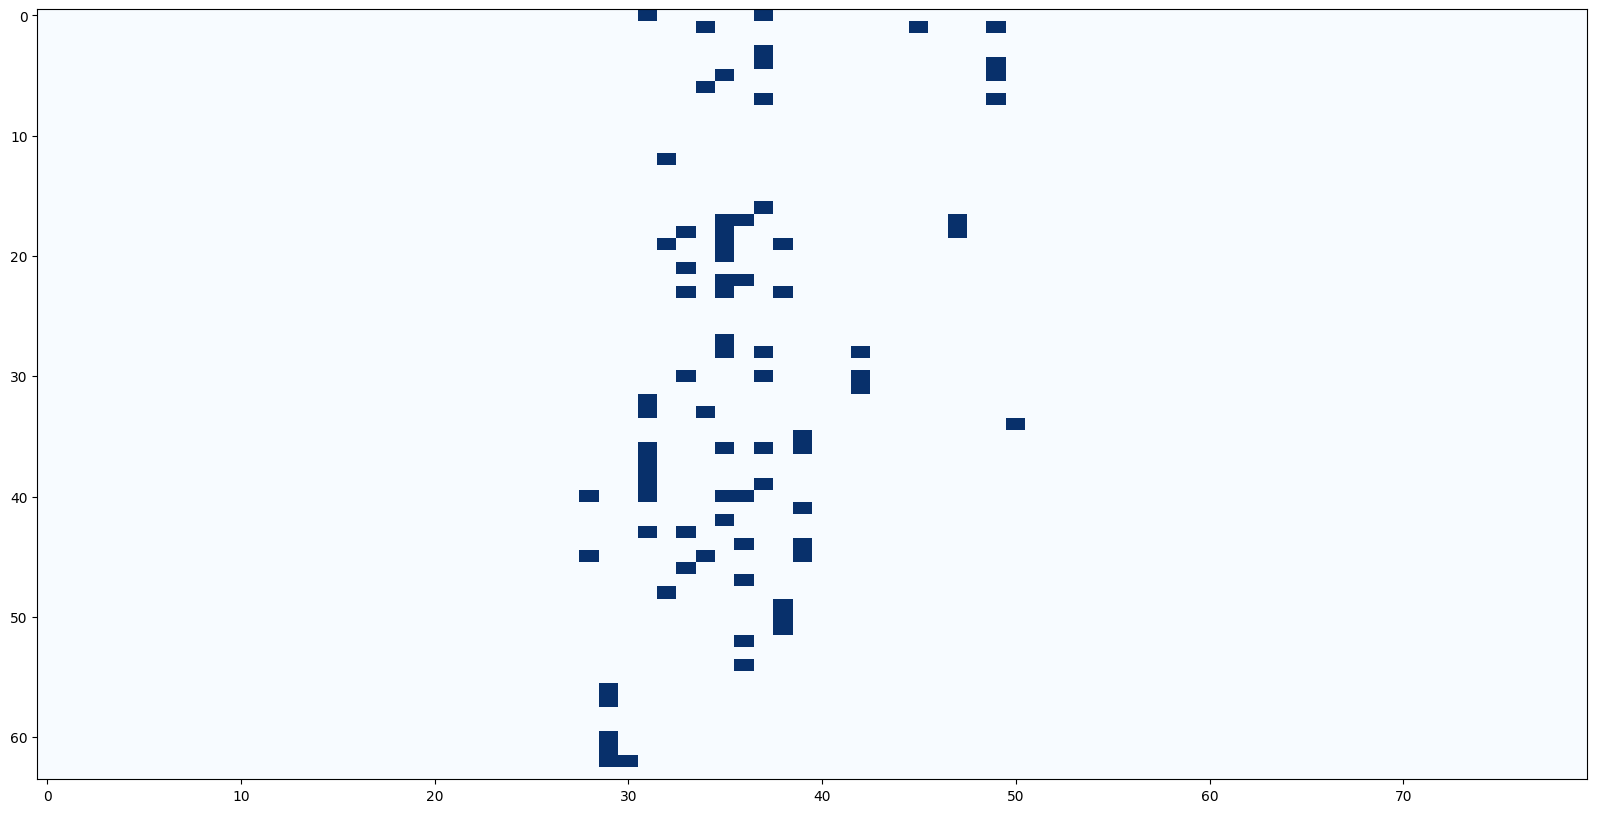

In [14]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads
# [(29, 3) in HEADS]

In [15]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=HEADS,
)

2025-09-24 14:19:15 src.selection.functional DEBUG    Predictions: ['" Strawberry"[89077] (p=0.605, logit=21.000)', '" The"[578] (p=0.174, logit=19.750)', '" Among"[22395] (p=0.093, logit=19.125)', '" A"[362] (p=0.073, logit=18.875)', '" strawberry"[73700] (p=0.006, logit=16.375)']
2025-09-24 14:19:15 src.selection.functional INFO     Combined attention matrix for all heads


## Cosine Similarity

In [16]:
from tqdm.auto import tqdm
import random

###########################################
limit = 100
prompt_template_idx=3
# option_style="single_line" --- IGNORE ---
###########################################

category_wise_samples = {}
for category in tqdm(select_task.categories):
    category_wise_samples[category] = []
    for idx in range(limit):
        sample = select_task.get_random_sample(
            mt=mt,
            category=category,  
            prompt_template_idx=prompt_template_idx,
            n_distractors=random.choice(range(2, 7)),
            filter_by_lm_prediction=True,
            option_style=random.choice(["single_line", "numbered", "bulleted"])
        )
        category_wise_samples[category].append(sample)

  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-24 14:20:05 src.selection.data ERROR    Sample = Train -> Bike (0): ['Bike', 'Blueberry', 'Skateboard', 'Pendant', 'Elephant']
    Top prediction (1, PredictedToken(token=' Skate', prob=0.349609375, logit=19.875, token_id=97796, metadata=None)) does not match the object Bike[38930, " Bike"].
    Retry count: 1. Retrying ...
    
2025-09-24 14:20:20 src.selection.data ERROR    Sample = Nightstand -> Stool (2): ['Bathtub', 'Hospital', 'Stool', 'Jacket', 'Bat', 'Chain', 'Guitar']
    Top prediction (1, PredictedToken(token=' Bat', prob=0.5625, logit=21.5, token_id=16488, metadata=None)) does not match the object Stool[800, " St"].
    Retry count: 1. Retrying ...
    
2025-09-24 14:20:23 src.selection.data ERROR    Sample = Sofa -> Wardrobe (5): ['Cucumber', 'Airplane', 'Palm', 'Binder', 'Jeans', 'Wardrobe']
    Top prediction (10, PredictedToken(token=' C', prob=0.00830078125, logit=16.125, token_id=356, metadata=None)) does not match the object Wardrobe[27738, " Ward"].
    Retr

In [17]:
from src.tokens import prepare_input
from src.selection.functional import cache_q_projections
import random
import copy

heads = copy.deepcopy(optimized_heads)

# all_heads = [
#     (layer_idx, head_idx)
#     for layer_idx in range(mt.n_layer)
#     for head_idx in range(mt.config.num_attention_heads)
# ]
# heads = random.sample(all_heads, len(optimized_heads))

heads = sorted(heads)

logger.info("Caching the predicate directions")
category_wise_q_states = {category: None for category in select_task.categories}

for category in tqdm(select_task.categories):
    prompts = [sample.prompt() for sample in category_wise_samples[category]]
    tokenized_prompts = prepare_input(
        prompts=prompts,
        tokenizer=mt.tokenizer,
    )
    category_wise_q_states[category] = cache_q_projections(
        mt=mt,
        input=tokenized_prompts,
        heads=heads,
        token_indices=[[-3, -2, -1] for _ in range(len(prompts))],
        projection_signature=".q_proj"
    )

2025-09-24 14:41:54 __main__ INFO     Caching the predicate directions


  0%|          | 0/16 [00:00<?, ?it/s]

In [18]:
category_wise_q_states["fruit"][0][heads[0] + (-1,)].shape

torch.Size([128])

In [19]:
category_wise_cosine_sim = {}

for category in tqdm(select_task.categories):
    category_wise_cosine_sim[category] = {}
    q_states = category_wise_q_states[category]
    for head in heads:
        q_head = torch.stack(
            [q_state[head + (-1,)] for q_state in q_states], dim=0
        )
        q_head = q_head / q_head.norm(dim=-1, keepdim=True)
        cosine_sim = (q_head @ q_head.T).to(torch.float32)
        category_wise_cosine_sim[category][head] = cosine_sim


for head in heads:
    sims = torch.stack(
        [category_wise_cosine_sim[category][head].mean() for category in select_task.categories],
        dim=0
    )
    logger.info(f"Head {head} >> {sims.mean().item():.4f} ± {sims.std().item():.4f}")

  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-24 14:45:53 __main__ INFO     Head (28, 40) >> 0.9613 ± 0.0059
2025-09-24 14:45:53 __main__ INFO     Head (28, 45) >> 0.9570 ± 0.0080
2025-09-24 14:45:53 __main__ INFO     Head (29, 56) >> 0.9437 ± 0.0078
2025-09-24 14:45:53 __main__ INFO     Head (29, 57) >> 0.9569 ± 0.0063
2025-09-24 14:45:53 __main__ INFO     Head (29, 60) >> 0.9685 ± 0.0048
2025-09-24 14:45:53 __main__ INFO     Head (29, 61) >> 0.9613 ± 0.0055
2025-09-24 14:45:53 __main__ INFO     Head (29, 62) >> 0.9827 ± 0.0024
2025-09-24 14:45:53 __main__ INFO     Head (30, 62) >> 0.9789 ± 0.0024
2025-09-24 14:45:53 __main__ INFO     Head (31, 0) >> 0.9362 ± 0.0101
2025-09-24 14:45:53 __main__ INFO     Head (31, 32) >> 0.9332 ± 0.0107
2025-09-24 14:45:53 __main__ INFO     Head (31, 33) >> 0.9407 ± 0.0109
2025-09-24 14:45:53 __main__ INFO     Head (31, 36) >> 0.9311 ± 0.0089
2025-09-24 14:45:53 __main__ INFO     Head (31, 37) >> 0.9309 ± 0.0094
2025-09-24 14:45:53 __main__ INFO     Head (31, 38) >> 0.9376 ± 0.0098
2025-09

In [20]:
category_wise_cosine_sim["fruit"].keys()

dict_keys([(28, 40), (28, 45), (29, 56), (29, 57), (29, 60), (29, 61), (29, 62), (30, 62), (31, 0), (31, 32), (31, 33), (31, 36), (31, 37), (31, 38), (31, 39), (31, 40), (31, 43), (32, 12), (32, 19), (32, 48), (33, 18), (33, 21), (33, 23), (33, 30), (33, 43), (33, 46), (34, 1), (34, 6), (34, 33), (34, 45), (35, 5), (35, 17), (35, 18), (35, 19), (35, 20), (35, 22), (35, 23), (35, 27), (35, 28), (35, 36), (35, 40), (35, 42), (36, 17), (36, 22), (36, 40), (36, 44), (36, 47), (36, 52), (36, 54), (37, 0), (37, 3), (37, 4), (37, 7), (37, 16), (37, 28), (37, 30), (37, 36), (37, 39), (38, 19), (38, 23), (38, 49), (38, 50), (38, 51), (39, 35), (39, 36), (39, 41), (39, 44), (39, 45), (42, 28), (42, 30), (42, 31), (45, 1), (47, 17), (47, 18), (49, 1), (49, 4), (49, 5), (49, 7), (50, 34)])

In [21]:
for category in select_task.categories:
    sim_matrix = category_wise_cosine_sim[category][(35, 19)]
    logger.info(f"{category} >> {sim_matrix.mean().item():.4f} ± {sim_matrix.std().item():.4f}")

2025-09-24 14:46:17 __main__ INFO     fruit >> 0.9233 ± 0.0307
2025-09-24 14:46:17 __main__ INFO     vehicle >> 0.8996 ± 0.0356
2025-09-24 14:46:17 __main__ INFO     furniture >> 0.8919 ± 0.0381
2025-09-24 14:46:17 __main__ INFO     animal >> 0.9148 ± 0.0334
2025-09-24 14:46:17 __main__ INFO     music instrument >> 0.8925 ± 0.0388
2025-09-24 14:46:17 __main__ INFO     clothing >> 0.8822 ± 0.0409
2025-09-24 14:46:17 __main__ INFO     electronics >> 0.9037 ± 0.0354
2025-09-24 14:46:17 __main__ INFO     sport equipment >> 0.9092 ± 0.0333
2025-09-24 14:46:17 __main__ INFO     kitchen appliance >> 0.8964 ± 0.0391
2025-09-24 14:46:17 __main__ INFO     vegetable >> 0.9102 ± 0.0362
2025-09-24 14:46:17 __main__ INFO     building >> 0.8766 ± 0.0473
2025-09-24 14:46:17 __main__ INFO     office supply >> 0.8950 ± 0.0381
2025-09-24 14:46:17 __main__ INFO     bathroom item >> 0.8763 ± 0.0412
2025-09-24 14:46:17 __main__ INFO     flower >> 0.9045 ± 0.0368
2025-09-24 14:46:17 __main__ INFO     tree >>

In [22]:
across_category_cosine_sim = {}
for head in heads:
    across_category_cosine_sim[head] = {}
    for category in select_task.categories:
        across_category_cosine_sim[head][category] = {}
        q_states = category_wise_q_states[category]
        q_head = torch.stack(
            [q_state[head + (-1,)] for q_state in q_states], dim=0
        )
        q_head = q_head / q_head.norm(dim=-1, keepdim=True)
        for other_category in select_task.categories:
            other_q_states = category_wise_q_states[other_category]
            other_q_head = torch.stack(
                [q_state[head + (-1,)] for q_state in other_q_states], dim=0
            )
            other_q_head = other_q_head / other_q_head.norm(dim=-1, keepdim=True)
            cosine_sim = (q_head @ other_q_head.T).to(torch.float32)
            across_category_cosine_sim[head][category][other_category] = cosine_sim

In [24]:
for category in select_task.categories:
    print(f"Category: {category}")
    for other_category in select_task.categories:
        sim_matrix = across_category_cosine_sim[(35, 19)][category][other_category]
        logger.info(
            f"{other_category} >> {sim_matrix.mean().item():.4f} ± {sim_matrix.std().item():.4f}"
        )
    
    break

Category: fruit
2025-09-24 14:52:06 __main__ INFO     fruit >> 0.9233 ± 0.0307
2025-09-24 14:52:06 __main__ INFO     vehicle >> 0.7138 ± 0.0447
2025-09-24 14:52:06 __main__ INFO     furniture >> 0.6829 ± 0.0552
2025-09-24 14:52:06 __main__ INFO     animal >> 0.8159 ± 0.0438
2025-09-24 14:52:06 __main__ INFO     music instrument >> 0.7576 ± 0.0496
2025-09-24 14:52:06 __main__ INFO     clothing >> 0.7493 ± 0.0547
2025-09-24 14:52:06 __main__ INFO     electronics >> 0.6854 ± 0.0486
2025-09-24 14:52:06 __main__ INFO     sport equipment >> 0.7266 ± 0.0466
2025-09-24 14:52:06 __main__ INFO     kitchen appliance >> 0.7379 ± 0.0543
2025-09-24 14:52:06 __main__ INFO     vegetable >> 0.8888 ± 0.0377
2025-09-24 14:52:06 __main__ INFO     building >> 0.6448 ± 0.0580
2025-09-24 14:52:06 __main__ INFO     office supply >> 0.7066 ± 0.0540
2025-09-24 14:52:06 __main__ INFO     bathroom item >> 0.7424 ± 0.0562
2025-09-24 14:52:06 __main__ INFO     flower >> 0.8819 ± 0.0360
2025-09-24 14:52:06 __main__ 

## Composition

In [105]:
import random
import copy
from src.tokens import prepare_input
from src.selection.utils import KeyedSet


def get_composition_samples(
    task: SelectOneTask,
    mt: ModelandTokenizer,
    unit_categories: list[str],
    prompt_template_idx=3,
    option_style="single_line",
    filter_by_lm_prediction: bool = True,
    n_distractors: int = 5,
):
    unit_samples = []
    for category in unit_categories:
        unit_samples.append(
            task.get_random_sample(
                mt=mt,
                category=category,
                prompt_template_idx=prompt_template_idx,
                option_style=option_style,
                filter_by_lm_prediction=filter_by_lm_prediction,
                n_distractors=n_distractors,
                exclude_distractor_categories=task.exclude_for_category(category)
            )
        )

    exclude_objs = [sample.obj for sample in unit_samples]
    clean_category = random.choice(list(set(task.categories) - set(unit_categories)))
    target_category = random.choice(unit_categories)
    target_obj = random.choice(
        (
            KeyedSet(
                items=task.category_wise_examples[target_category],
                tokenizer=mt.tokenizer,
            )
            - KeyedSet(items=exclude_objs, tokenizer=mt.tokenizer)
        ).values
    )
    obj_idx = random.randint(0, n_distractors)
    target_idx = random.choice([i for i in range(n_distractors + 1) if i != obj_idx])

    exclude_clean_distractor_categories = copy.deepcopy(unit_categories)
    for category in unit_categories:
        # print(category, task.exclude_for_category(category))
        exclude_clean_distractor_categories.extend(task.exclude_for_category(category))
    exclude_clean_distractor_categories = list(set(exclude_clean_distractor_categories))
    print(f"{len(exclude_clean_distractor_categories)} | {exclude_clean_distractor_categories}")

    clean_sample = task.get_random_sample(
        mt=mt,
        category=clean_category,
        obj_idx=obj_idx,
        prompt_template_idx=prompt_template_idx,
        option_style=option_style,
        filter_by_lm_prediction=filter_by_lm_prediction,
        n_distractors=n_distractors,
        exclude_objs=exclude_objs,
        exclude_distractor_categories=exclude_clean_distractor_categories,
        insert_distractor=[(target_obj, target_idx)],
    )
    comp_sample = copy.deepcopy(clean_sample)
    comp_sample.category = " or ".join(unit_categories)
    comp_sample.obj = target_obj
    comp_sample.obj_idx = target_idx
    assert (
        "<_category_>" in comp_sample.prompt_template
    ), "Composition prompt template must have <_category_> token"
    # comp_sample.prompt_template = comp_sample.prompt_template.replace(
    #     "<_category_>", " or ".join(unit_categories)
    # )

    if filter_by_lm_prediction:
        tokenized = prepare_input(tokenizer=mt, prompts=comp_sample.prompt())
        is_correct, predictions, track_options = verify_correct_option(
            mt=mt,
            target=comp_sample.obj,
            options=comp_sample.options,
            input=tokenized,
        )
        comp_sample.metadata["tokenized"] = tokenized

        logger.debug(comp_sample.prompt())
        logger.debug(
            f"{comp_sample.subj} | {comp_sample.category} -> {comp_sample.obj} | pred={[str(p) for p in predictions]}"
        )
        if not is_correct:
            logger.error(
                f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {comp_sample.ans_token_id}["{mt.tokenizer.decode(comp_sample.ans_token_id)}"]'
            )
            return get_composition_samples(
                task=task,
                mt=mt,
                unit_categories=unit_categories,
                prompt_template_idx=prompt_template_idx,
                option_style=option_style,
                filter_by_lm_prediction=filter_by_lm_prediction,
                n_distractors=n_distractors,
            )
        comp_sample.prediction = predictions

    return unit_samples, clean_sample, comp_sample


unit_samples, clean_sample, comp_sample = get_composition_samples(
    task=select_task,
    mt=mt,
    unit_categories=["fruit", "vehicle"],
    prompt_template_idx=3,
    option_style="single_line",
    filter_by_lm_prediction=True,
    n_distractors=5,
)

5 | ['flower', 'vegetable', 'vehicle', 'tree', 'fruit']
2025-09-22 14:06:06 __main__ DEBUG    Options: Blueberry, Earring, Tie, Warehouse, Trumpet, Nightstand.
Which among these objects mentioned above is a fruit or vehicle?
Answer:
2025-09-22 14:06:06 __main__ DEBUG    Clarinet | fruit or vehicle -> Blueberry | pred=['" Blue"[8868] (p=0.652, logit=19.750)', '" The"[578] (p=0.088, logit=17.750)', '" Among"[22395] (p=0.061, logit=17.375)', '" Fruit"[44187] (p=0.042, logit=17.000)', '" A"[362] (p=0.032, logit=16.750)']


In [106]:
# failed_case_idx = 10
# failed_case = failed_cases[failed_case_idx]
# unit_samples = failed_case["unit_samples"]
# clean_sample = failed_case["clean_sample"]
# comp_sample = failed_case["comp_sample"]

In [107]:
print(clean_sample.prompt(), ">>", clean_sample.obj)
print(comp_sample.prompt(), ">>", comp_sample.obj)

Options: Blueberry, Earring, Tie, Warehouse, Trumpet, Nightstand.
Which among these objects mentioned above is a music instrument?
Answer: >> Trumpet
Options: Blueberry, Earring, Tie, Warehouse, Trumpet, Nightstand.
Which among these objects mentioned above is a fruit or vehicle?
Answer: >> Blueberry


In [108]:
from src.functional import generate_with_patch
mt.reset_forward()
mt.set_attn_implementation("eager")

for sample in unit_samples:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        # heads=[(35, 19)],
        # generate_full_answer=True,
        query_index=-1
    )

for sample in [clean_sample, comp_sample]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        # heads=[(35, 19)],
        # generate_full_answer=True,
        query_index=-1
    )

Options: Shampoo, Strawberry, Xylophone, Warehouse, Library, Library.
Which among these objects mentioned above is a fruit?
Answer: >> Strawberry
2025-09-22 14:06:08 src.selection.functional DEBUG    Predictions: ['" Strawberry"[89077] (p=0.641, logit=20.500)', '" The"[578] (p=0.143, logit=19.000)', '" Among"[22395] (p=0.076, logit=18.375)', '" Sh"[1443] (p=0.028, logit=17.375)', '" A"[362] (p=0.019, logit=17.000)']
2025-09-22 14:06:08 src.selection.functional INFO     Combined attention matrix for all heads


Options: Harp, Juicer, Bathtub, Boat, Sweater, Piano.
Which among these objects mentioned above is a vehicle?
Answer: >> Boat
2025-09-22 14:06:09 src.selection.functional DEBUG    Predictions: ['" Boat"[45332] (p=0.730, logit=22.250)', '" The"[578] (p=0.087, logit=20.125)', '" A"[362] (p=0.087, logit=20.125)', '" Among"[22395] (p=0.053, logit=19.625)', '" It"[1102] (p=0.006, logit=17.375)']
2025-09-22 14:06:09 src.selection.functional INFO     Combined attention matrix for all heads


Options: Blueberry, Earring, Tie, Warehouse, Trumpet, Nightstand.
Which among these objects mentioned above is a music instrument?
Answer: >> Trumpet
2025-09-22 14:06:09 src.selection.functional DEBUG    Predictions: ['" Trump"[3420] (p=0.820, logit=22.375)', '" The"[578] (p=0.098, logit=20.250)', '" A"[362] (p=0.032, logit=19.125)', '" Among"[22395] (p=0.025, logit=18.875)', '" It"[1102] (p=0.004, logit=17.000)']
2025-09-22 14:06:09 src.selection.functional INFO     Combined attention matrix for all heads


Options: Blueberry, Earring, Tie, Warehouse, Trumpet, Nightstand.
Which among these objects mentioned above is a fruit or vehicle?
Answer: >> Blueberry
2025-09-22 14:06:09 src.selection.functional DEBUG    Predictions: ['" Blue"[8868] (p=0.652, logit=19.750)', '" The"[578] (p=0.088, logit=17.750)', '" Among"[22395] (p=0.061, logit=17.375)', '" Fruit"[44187] (p=0.042, logit=17.000)', '" A"[362] (p=0.032, logit=16.750)']
2025-09-22 14:06:09 src.selection.functional INFO     Combined attention matrix for all heads


In [109]:
from src.selection.functional import cache_q_projections
from src.utils.typing import TokenizerOutput
from src.tokens import prepare_input, find_token_range

query_indices = {-3: -3, -2: -2, -1: -1}

unit_query_states = []
for sample in unit_samples:
    if "tokenized" in sample.metadata:
        tokenized = TokenizerOutput(data=sample.metadata["tokenized"])
    else:
        tokenized = prepare_input(prompts=sample.prompt(), tokenizer=mt.tokenizer)
    unit_query_states.append(
        cache_q_projections(
            mt=mt,
            input=tokenized,
            heads=optimized_heads,
            token_indices=[list(query_indices.keys())],
            return_output=False
        )[0]
    )

In [110]:
from src.functional import PatchSpec, patch_with_baukit, interpret_logits
from src.selection.utils import get_first_token_id

combined_q_proj_patches = []

for layer_idx, head_idx, query_idx in unit_query_states[0]:
    proj = torch.stack([
        query_state[(layer_idx, head_idx, query_idx)] for query_state in unit_query_states
    ]).squeeze().sum(dim=0)
    combined_q_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_idx,
            ),
            patch=proj,
        )
    )

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt.tokenizer)

comp_attn = verify_head_patterns(
    prompt=clean_sample.prompt(),
    tokenized_prompt=clean_tokenized,
    mt=mt,
    heads=optimized_heads,
    # heads=[(35, 19)],
    # generate_full_answer=True,
    query_index=-1,
    query_patches=combined_q_proj_patches,
)

patched_out = patch_with_baukit(
    mt=mt,
    inputs=clean_tokenized,
    patches=combined_q_proj_patches,
)
patched_logits = patched_out.logits[:, -1, :].squeeze()
patched_pred, patched_track = interpret_logits(
    tokenizer=mt.tokenizer,
    logits=patched_logits,
    k=10,
    interested_tokens = [
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in clean_sample.options
    ]
)
patched_track

2025-09-22 14:06:16 src.selection.functional DEBUG    Predictions: ['" E"[469] (p=0.445, logit=21.250)', '" Blue"[8868] (p=0.393, logit=21.125)', '" The"[578] (p=0.087, logit=19.625)', '" An"[1556] (p=0.020, logit=18.125)', '" Among"[22395] (p=0.017, logit=18.000)']
2025-09-22 14:06:16 src.selection.functional INFO     Combined attention matrix for all heads


OrderedDict([(469,
              (1,
               PredictedToken(token=' E', prob=0.4453125, logit=21.25, token_id=469, metadata=None))),
             (8868,
              (2,
               PredictedToken(token=' Blue', prob=0.392578125, logit=21.125, token_id=8868, metadata=None))),
             (13120,
              (74,
               PredictedToken(token=' Night', prob=3.552436828613281e-05, logit=11.8125, token_id=13120, metadata=None))),
             (3420,
              (215,
               PredictedToken(token=' Trump', prob=4.500150680541992e-06, logit=9.75, token_id=3420, metadata=None))),
             (59825,
              (401,
               PredictedToken(token=' Tie', prob=1.2889504432678223e-06, logit=8.5, token_id=59825, metadata=None))),
             (52466,
              (3487,
               PredictedToken(token=' Warehouse', prob=5.494803190231323e-08, logit=5.34375, token_id=52466, metadata=None)))])

In [56]:
# failed_case["patched_pred"], failed_case["patched_track"]

In [57]:
# failed_case["clean_pred"], failed_case["clean_track"]

## Scale Up

In [69]:
from dataclasses import dataclass
from dataclasses_json import DataClassJsonMixin
from typing import Union
from src.selection.data import SelectionSample, CountingSample, YesNoSample

@dataclass
class CounterFactualforComposition(DataClassJsonMixin):
    unit_samples: list[Union[SelectionSample, CountingSample, YesNoSample]]
    clean_sample: Union[SelectionSample, CountingSample, YesNoSample]
    comp_sample: Union[SelectionSample, CountingSample, YesNoSample]

    @staticmethod
    def sample_type_to_class():
        return {
            "selection": SelectionSample,
            "counting": CountingSample,
            "yes_no": YesNoSample,
        }

    def detensorize(self):
        for sample in self.unit_samples + [self.clean_sample, self.comp_sample]:
            class_name = type(sample).__name__
            type_to_name = {
                "SelectionSample": "selection",
                "CountingSample": "counting",
                "YesNoSample": "yes_no",
            }
            sample.metadata["sample_type"] = type_to_name[class_name]
            sample.detensorize()

    @staticmethod
    def from_dict(d):
        unit_samples = []
        for sample_dict in d["unit_samples"]:
            sample_type = sample_dict["metadata"].pop("sample_type")
            sample_cls = CounterFactualforComposition.sample_type_to_class()[sample_type]
            unit_samples.append(sample_cls.from_dict(sample_dict))
        
        comp_sample_type = d["comp_sample"]["metadata"].pop("sample_type")
        comp_sample_cls = CounterFactualforComposition.sample_type_to_class()[comp_sample_type]
        comp_sample = comp_sample_cls.from_dict(d["comp_sample"])

        clean_sample_type = d["clean_sample"]["metadata"].pop("sample_type")
        clean_sample_cls = CounterFactualforComposition.sample_type_to_class()[clean_sample_type]
        clean_sample = clean_sample_cls.from_dict(d["clean_sample"])

        return CounterFactualforComposition(
            unit_samples=unit_samples,
            comp_sample=comp_sample,
            clean_sample=clean_sample,
        )

In [89]:
from src.functional import free_gpu_cache

test_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation_composition",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
)
os.makedirs(test_samples_save_path, exist_ok=True)

free_gpu_cache()


#########################################
test_limit = 512
start_number = 1
#########################################
test_set = []

test_set = []
while len(test_set) < test_limit:
    print(f"sample {len(test_set)+1} / {test_limit}")
    unit_samples, clean_sample, comp_sample = get_composition_samples(
        task=select_task,
        mt=mt,
        unit_categories=random.sample(select_task.categories, 2),
        prompt_template_idx=3,
        option_style="single_line",
        filter_by_lm_prediction=True,
        n_distractors=random.choice(range(2, 6)),
    )
    test_set.append((unit_samples, clean_sample, comp_sample))
    counterfactual = CounterFactualforComposition(
        unit_samples=unit_samples,
        clean_sample=clean_sample,
        comp_sample=comp_sample,
    )
    counterfactual.detensorize()
    comp_sample.metadata.pop("tokenized", None)
    with open(
        os.path.join(test_samples_save_path, f"{len(test_set) + start_number - 1:05d}.json"),
        "w",
    ) as f:
        json.dump(counterfactual.to_dict(), f, indent=2)

len(test_set)

sample 1 / 512
2 | ['furniture', 'building']
2025-09-22 12:19:28 __main__ DEBUG    Options: Airplane, Plum, Airplane, House, Toilet paper.
Which among these objects mentioned above is a building or furniture?
Answer:
2025-09-22 12:19:28 __main__ DEBUG    Orange | building or furniture -> House | pred=['" House"[4783] (p=0.719, logit=20.875)', '" The"[578] (p=0.067, logit=18.500)', '" Among"[22395] (p=0.052, logit=18.250)', '" Toilet"[82994] (p=0.041, logit=18.000)', '" A"[362] (p=0.019, logit=17.250)']
sample 2 / 512
4 | ['fruit', 'music instrument', 'flower', 'vegetable']
2025-09-22 12:19:31 __main__ DEBUG    Options: Binder, Birch, Celery, Willow.
Which among these objects mentioned above is a vegetable or music instrument?
Answer:
2025-09-22 12:19:31 __main__ DEBUG    Pencil | vegetable or music instrument -> Celery | pred=['" Cel"[47643] (p=0.512, logit=18.875)', '" The"[578] (p=0.101, logit=17.250)', '" Binder"[91263] (p=0.079, logit=17.000)', '" None"[2290] (p=0.061, logit=16.750

512

In [90]:
#########################################
test_set = []
test_limit = 512
#########################################

test_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation_composition",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(test_samples_load_path, f)
    for f in os.listdir(test_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

random.shuffle(sample_files)
sample_files = sample_files[:test_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_composition = json.load(f)
    cf_composition = CounterFactualforComposition.from_dict(cf_composition)
    test_set.append(
        (
            cf_composition.unit_samples,
            cf_composition.clean_sample,
            cf_composition.comp_sample,
        )
    )

len(test_set)

2025-09-22 13:51:18 __main__ INFO     Found 512 sample files


512

In [92]:
from src.selection.functional import cache_q_projections
from src.selection.functional import find_quesmark_pos

def cache_q_projections_with_avg_trick(
    mt: ModelandTokenizer,
    patch_sample: Union[SelectionSample, CountingSample, YesNoSample],
    heads: list[tuple[int, int]],
    token_indices: list[int],
    add_ques_pos_to_query_indices: bool = True,
):
    patch_samples = []
    while len(patch_samples) < len(patch_sample.options):
        obj_idx = len(patch_samples) % len(patch_sample.options)
        sample = copy.deepcopy(patch_sample)
        sample.options[obj_idx], sample.options[sample.obj_idx] = (
            sample.options[sample.obj_idx],
            sample.options[obj_idx],
        )
        sample.obj_idx = obj_idx
        patch_samples.append(sample)
    
    patch_tokenized_batch = prepare_input(
        prompts=[sample.prompt() for sample in patch_samples],
        tokenizer=mt.tokenizer,
        return_offsets_mapping=True,
    )
    patch_offset_mapping_batch = patch_tokenized_batch.pop("offset_mapping")
    patch_token_indices = []
    for idx in range(len(patch_samples)):
        cur_indices = {i: i for i in query_indices}
        if add_ques_pos_to_query_indices:
            patch_ques_pos = find_quesmark_pos(
                prompt=patch_samples[idx].prompt(),
                tokenizer=mt.tokenizer,
                tokenized=TokenizerOutput(
                    data={
                        k: v[idx : idx + 1, :]
                        for k, v in patch_tokenized_batch.items()
                    }
                ),
                offset_mapping=patch_offset_mapping_batch[idx],
            )
            cur_indices[patch_ques_pos] = '#'
        patch_token_indices.append(list(cur_indices.keys()))
    logger.debug(f"{patch_tokenized_batch.input_ids.shape}")


    cached_q_states = cache_q_projections(
        mt=mt,
        input=patch_tokenized_batch,
        heads=heads,
        token_indices=patch_token_indices,
        return_output=False,
    )
    locations = list(cached_q_states[0].keys())
    avg_q_states = {}
    for loc in locations:
        avg_q_states[loc] = torch.stack(
            [cached_q_states[i][loc] for i in range(len(cached_q_states))]
        ).mean(dim=0)
    cached_q_states = [avg_q_states]

    return cached_q_states

In [93]:
from tqdm.auto import tqdm
from src.functional import patch_with_baukit, interpret_logits
from src.selection.utils import get_first_token_id

query_indices = {-3: -3, -2: -2, -1: -1}
query_locations = [
    (layer_idx, head_idx, patch_query_idx)
    for layer_idx, head_idx in HEADS
    for patch_query_idx in query_indices.keys()
]

test_results = []
for unit_samples, clean_sample, comp_sample in tqdm(test_set):
    clean_obj = get_first_token_id(clean_sample.obj, tokenizer=mt.tokenizer)
    target_obj = get_first_token_id(comp_sample.obj, tokenizer=mt.tokenizer)

    unit_query_states = []
    for sample in unit_samples:
        # if "tokenized" in sample.metadata:
        #     tokenized = TokenizerOutput(data=sample.metadata["tokenized"])
        # else:
        unit_tokenized = prepare_input(prompts=sample.prompt(), tokenizer=mt.tokenizer)
        # print(tokenized)
        # unit_query_states.append(
        #     cache_q_projections(
        #         mt=mt,
        #         input=unit_tokenized,
        #         heads=optimized_heads,
        #         token_indices=[list(query_indices.keys())],
        #         return_output=False
        #     )[0]
        # )
        unit_query_states.append(
            cache_q_projections_with_avg_trick(
                mt=mt,
                patch_sample=sample,
                heads=optimized_heads,
                token_indices=list(query_indices.keys()),
                add_ques_pos_to_query_indices=False,
            )[0]
        )

    # inputs = TokenizerOutput(data=clean_sample.metadata["tokenized"])
    clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt.tokenizer)
    interested_tokens = [
        get_first_token_id(option, mt.tokenizer) for option in clean_sample.options
    ]

    # clean_run
    clean_output = patch_with_baukit(
        mt=mt,
        inputs=clean_tokenized,
    )
    clean_logits = clean_output.logits[:, -1, :]
    clean_pred, clean_track = interpret_logits(
        tokenizer=mt.tokenizer, logits=clean_logits, interested_tokens=interested_tokens
    )
    before_intervention = {
        "clean_rank": clean_track[clean_obj][0],
        "clean_logit": clean_track[clean_obj][1].logit,
        "target_rank": clean_track[target_obj][0],
        "target_logit": clean_track[target_obj][1].logit,
    }

    # patched run

    combined_q_proj_patches = []

    for layer_idx, head_idx, query_idx in unit_query_states[0]:
        proj = (
            torch.stack(
                [
                    query_state[(layer_idx, head_idx, query_idx)]
                    for query_state in unit_query_states
                ]
            )
            .squeeze()
            .sum(dim=0)
        )
        combined_q_proj_patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                    head_idx,
                    query_idx,
                ),
                patch=proj,
            )
        )
        
    patched_output = patch_with_baukit(
        mt=mt,
        inputs=clean_tokenized,
        patches=combined_q_proj_patches,
    )
    patched_logits = patched_output.logits[:, -1, :]
    patched_pred, patched_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=patched_logits,
        interested_tokens=interested_tokens,
    )
    after_intervention = {
        "clean_rank": patched_track[clean_obj][0],
        "clean_logit": patched_track[clean_obj][1].logit,
        "target_rank": patched_track[target_obj][0],
        "target_logit": patched_track[target_obj][1].logit,
    }

    test_results.append(
        {
            "unit_samples": unit_samples,
            "clean_sample": clean_sample,
            "comp_sample": comp_sample,
            "before_intervention": before_intervention,
            "after_intervention": after_intervention,
            "clean_pred": clean_pred,
            "clean_track": clean_track,
            "patched_pred": patched_pred,
            "patched_track": patched_track,
        }
    )

  0%|          | 0/512 [00:00<?, ?it/s]

2025-09-22 13:53:22 __main__ DEBUG    torch.Size([3, 23])
2025-09-22 13:53:22 __main__ DEBUG    torch.Size([3, 22])
2025-09-22 13:53:23 __main__ DEBUG    torch.Size([4, 25])
2025-09-22 13:53:23 __main__ DEBUG    torch.Size([4, 26])
2025-09-22 13:53:24 __main__ DEBUG    torch.Size([4, 25])
2025-09-22 13:53:24 __main__ DEBUG    torch.Size([4, 24])
2025-09-22 13:53:25 __main__ DEBUG    torch.Size([3, 24])
2025-09-22 13:53:25 __main__ DEBUG    torch.Size([3, 21])
2025-09-22 13:53:26 __main__ DEBUG    torch.Size([3, 25])
2025-09-22 13:53:26 __main__ DEBUG    torch.Size([3, 22])
2025-09-22 13:53:27 __main__ DEBUG    torch.Size([6, 30])
2025-09-22 13:53:27 __main__ DEBUG    torch.Size([6, 30])
2025-09-22 13:53:27 __main__ DEBUG    torch.Size([4, 24])
2025-09-22 13:53:28 __main__ DEBUG    torch.Size([4, 24])
2025-09-22 13:53:28 __main__ DEBUG    torch.Size([6, 32])
2025-09-22 13:53:29 __main__ DEBUG    torch.Size([6, 31])
2025-09-22 13:53:29 __main__ DEBUG    torch.Size([4, 26])
2025-09-22 13:

In [94]:
import numpy as np

clean_rank_delta = []
target_rank_delta = []
for result in test_results:
    clean_rank_delta.append(result["after_intervention"]["clean_rank"] - result["before_intervention"]["clean_rank"])
    target_rank_delta.append(result["after_intervention"]["target_rank"] - result["before_intervention"]["target_rank"])

clean_rank_delta = np.array(clean_rank_delta)
target_rank_delta = np.array(target_rank_delta)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [result["after_intervention"]["clean_rank"] for result in test_results]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [result["after_intervention"]["target_rank"] for result in test_results]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

print("="*100)

clean_logit_delta = []
target_logit_delta = []
for result in test_results:
    clean_logit_delta.append(result["after_intervention"]["clean_logit"] - result["before_intervention"]["clean_logit"])
    target_logit_delta.append(result["after_intervention"]["target_logit"] - result["before_intervention"]["target_logit"])

clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [result["after_intervention"]["clean_logit"] for result in test_results]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    result["after_intervention"]["target_logit"] for result in test_results
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

print("="*100)

counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in test_results:
    clean_sample = intervention_result["clean_sample"]
    comp_sample = intervention_result["comp_sample"]
    int_track = intervention_result["patched_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == get_first_token_id(comp_sample.obj, tokenizer=mt.tokenizer)
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(intervention_result)

top_1_accuracy = counter_patch_type_top_option / len(test_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(test_results)})"
)

clean_rank_delta: 65.6172 ± 163.3224
target_rank_delta: -148.6074 ± 367.3656
clean_rank_after_intervention: 66.6191 ± 163.3216
target_rank_after_intervention: 11.1582 ± 64.5583
clean_logit_delta: -7.0297 ± 3.4156
target_logit_delta: 6.7492 ± 3.9382
clean_logit_after_intervention: 14.7210 ± 3.4546
target_logit_after_intervention: 19.2672 ± 2.9980
Counterfactual patching accuracy: 0.6523 (334/512)
